## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

### Goals:
#### Use Scikit-Learn pipelines to define special features to add to a Naive Bayes Classifier
#### Evaluate the accuracy of the classifier
#### Maybe do it live, on a Twitter API stream

### Methods:
#### Use the training set I made before

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from time import time, sleep
from random import choice
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import json
import re

#### Set max column width for dataframes

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the CSV

In [4]:
df = pd.read_csv("../data/data_for_training/final_training_data/Subtweets_Classifier_Training_Data.csv")

#### Create training and test sets from the single training set I made before

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df.alleged_subtweet.tolist(), 
                                                                  df.is_subtweet.tolist())

#### Use NLTK's tokenizer instead of Scikit's

In [6]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [7]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        first_names = ["Aaliyah", "Aaron", "Abby", "Abigail", "Abraham", "Adam",
                       "Addison", "Adrian", "Adriana", "Adrianna", "Aidan", "Aiden",
                       "Alan", "Alana", "Alejandro", "Alex", "Alexa", "Alexander",
                       "Alexandra", "Alexandria", "Alexia", "Alexis", "Alicia", "Allison",
                       "Alondra", "Alyssa", "Amanda", "Amber", "Amelia", "Amy",
                       "Ana", "Andrea", "Andres", "Andrew", "Angel", "Angela",
                       "Angelica", "Angelina", "Anna", "Anthony", "Antonio", "Ariana",
                       "Arianna", "Ashley", "Ashlyn", "Ashton", "Aubrey", "Audrey",
                       "Austin", "Autumn", "Ava", "Avery", "Ayden", "Bailey",
                       "Benjamin", "Bianca", "Blake", "Braden", "Bradley", "Brady",
                       "Brandon", "Brayden", "Breanna", "Brendan", "Brian", "Briana",
                       "Brianna", "Brittany", "Brody", "Brooke", "Brooklyn", "Bryan",
                       "Bryce", "Bryson", "Caden", "Caitlin", "Caitlyn", "Caleb",
                       "Cameron", "Camila", "Carlos", "Caroline", "Carson", "Carter",
                       "Cassandra", "Cassidy", "Catherine", "Cesar", "Charles", "Charlotte",
                       "Chase", "Chelsea", "Cheyenne", "Chloe", "Christian", "Christina",
                       "Christopher", "Claire", "Cody", "Colby", "Cole", "Colin",
                       "Collin", "Colton", "Conner", "Connor", "Cooper", "Courtney",
                       "Cristian", "Crystal", "Daisy", "Dakota", "Dalton", "Damian",
                       "Daniel", "Daniela", "Danielle", "David", "Delaney", "Derek",
                       "Destiny", "Devin", "Devon", "Diana", "Diego", "Dominic",
                       "Donovan", "Dylan", "Edgar", "Eduardo", "Edward", "Edwin",
                       "Eli", "Elias", "Elijah", "Elizabeth", "Ella", "Ellie", 
                       "Emily", "Emma", "Emmanuel", "Eric", "Erica", "Erick",
                       "Erik", "Erin", "Ethan", "Eva", "Evan", "Evelyn",
                       "Faith", "Fernando", "Francisco", "Gabriel", "Gabriela", "Gabriella",
                       "Gabrielle", "Gage", "Garrett", "Gavin", "Genesis", "George",
                       "Gianna", "Giovanni", "Giselle", "Grace", "Gracie", "Grant",
                       "Gregory", "Hailey", "Haley", "Hannah", "Hayden", "Hector",
                       "Henry", "Hope", "Hunter", "Ian", "Isaac", "Isabel",
                       "Isabella", "Isabelle", "Isaiah", "Ivan", "Jack", "Jackson",
                       "Jacob", "Jacqueline", "Jada", "Jade", "Jaden", "Jake",
                       "Jalen", "James", "Jared", "Jasmin", "Jasmine", "Jason", 
                       "Javier", "Jayden", "Jayla", "Jazmin", "Jeffrey", "Jenna",
                       "Jennifer", "Jeremiah", "Jeremy", "Jesse", "Jessica", "Jesus",
                       "Jillian", "Jocelyn", "Joel", "John", "Johnathan", "Jonah",
                       "Jonathan", "Jordan", "Jordyn", "Jorge", "Jose", "Joseph",
                       "Joshua", "Josiah", "Juan", "Julia", "Julian", "Juliana",
                       "Justin", "Kaden", "Kaitlyn", "Kaleb", "Karen", "Karina",
                       "Kate", "Katelyn", "Katherine", "Kathryn", "Katie", "Kayla",
                       "Kaylee", "Kelly", "Kelsey", "Kendall", "Kennedy", "Kenneth",
                       "Kevin", "Kiara", "Kimberly", "Kyle", "Kylee", "Kylie",
                       "Landon", "Laura", "Lauren", "Layla", "Leah", "Leonardo",
                       "Leslie", "Levi", "Liam", "Liliana", "Lillian", "Lilly",
                       "Lily", "Lindsey", "Logan", "Lucas", "Lucy", "Luis",
                       "Luke", "Lydia", "Mackenzie", "Madeline", "Madelyn", "Madison",
                       "Makayla", "Makenzie", "Malachi", "Manuel", "Marco", "Marcus",
                       "Margaret", "Maria", "Mariah", "Mario", "Marissa", "Mark",
                       "Martin", "Mary", "Mason", "Matthew", "Max", "Maxwell",
                       "Maya", "Mckenzie", "Megan", "Melanie", "Melissa", "Mia",
                       "Micah", "Michael", "Michelle", "Miguel", "Mikayla", "Miranda",
                       "Molly", "Morgan", "Mya", "Naomi", "Natalia", "Natalie",
                       "Nathan", "Nathaniel", "Nevaeh", "Nicholas", "Nicolas", "Nicole",
                       "Noah", "Nolan", "Oliver", "Olivia", "Omar", "Oscar",
                       "Owen", "Paige", "Parker", "Patrick", "Paul", "Payton",
                       "Peter", "Peyton", "Preston", "Rachel", "Raymond", "Reagan",
                       "Rebecca", "Ricardo", "Richard", "Riley", "Robert", "Ruby",
                       "Ryan", "Rylee", "Sabrina", "Sadie", "Samantha", "Samuel",
                       "Sara", "Sarah", "Savannah", "Sean", "Sebastian", "Serenity",
                       "Sergio", "Seth", "Shane", "Shawn", "Shelby", "Sierra",
                       "Skylar", "Sofia", "Sophia", "Sophie", "Spencer", "Stephanie",
                       "Stephen", "Steven", "Summer", "Sydney", "Tanner", "Taylor", 
                       "Thomas", "Tiffany", "Timothy", "Travis", "Trenton", "Trevor",
                       "Trinity", "Tristan", "Tyler", "Valeria", "Valerie", "Vanessa",
                       "Veronica", "Victor", "Victoria", "Vincent", "Wesley", "William",
                       "Wyatt", "Xavier", "Zachary", "Zoe", "Zoey"]
        first_names_lower = set([name.lower() for name in first_names])

        pronouns = ["You", "You're", "Youre", "Your", "U", "Ur",
                    "She", "She's", "Her", "Hers", 
                    "He", "He's", "Hes", "Him", "His", 
                    "They", "They're", "Theyre", "Them", "Their", "Theirs"]
        prounouns_lower = set([pronoun.lower() for pronoun in pronouns])
        
        first_person_pronouns = ["I", "I'm", "Im", "We", "We're", "Our", "My", "Us"]
        first_person_pronouns_lower = set([pronoun.lower() for pronoun in first_person_pronouns])
        
        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            
            num_pronouns = len(prounouns_lower.intersection(tokenized_text))
            num_names = len(first_names_lower.intersection(tokenized_text))
            num_first_person = len(first_person_pronouns_lower.intersection(tokenized_text))
            num_at_symbols = text.count("@")
            num_subtweet = text.count("subtweet") + text.count("Subtweet")
            num_urls = len(re.findall(pattern, text))
            
            
            weighted_dict = {"num_subtweet": bool(num_subtweet),
                             "num_at_symbols": bool(num_at_symbols), 
                             "num_urls": bool(num_urls),
                             "num_pronouns": bool(num_pronouns),
                             "num_names": bool(num_names), 
                             "num_first_person": bool(num_first_person)}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [8]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer())
        ]))
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [9]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [10]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.96      0.85      0.90      1414
   positive       0.87      0.97      0.92      1502

avg / total       0.92      0.91      0.91      2916



#### Define function for visualizing confusion matrices

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

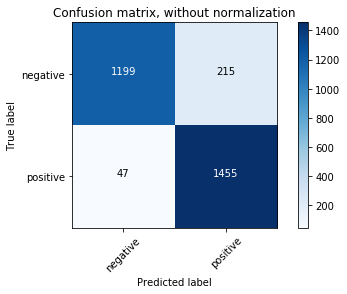

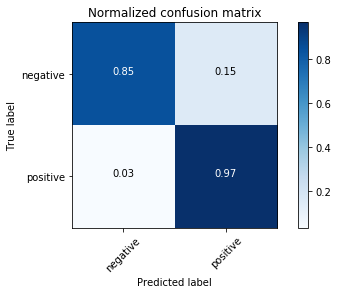

In [12]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [13]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [14]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [15]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [16]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [17]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1,None,0.070027,0.929973,Isn't it funny how some people don't know their place?
0,None,0.070194,0.929806,Some people don't know their place.
2,None,0.122182,0.877818,How come you people act like this?
5,None,0.247561,0.752439,Who the heck is Noah?
4,None,0.282461,0.717539,"I love Noah, he's so cool."


#### Test on actual tweets

In [18]:
naji_df = pd.read_csv("../data/data_for_testing/other_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [19]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [20]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [21]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [22]:
print("Length of dataset: {}".format(len(naji_df)))

Length of dataset: 1564156


#### Use randomly selected 10K rows from dataset

In [23]:
naji_df = naji_df.sample(n=10000).reset_index(drop=True)

#### Print and time the tests

In [24]:
%%time
naji_df = tests_dataframe(naji_df)

CPU times: user 2.11 s, sys: 50.3 ms, total: 2.16 s
Wall time: 2.28 s


In [25]:
naji_df.to_csv("../data/data_from_testing/other_data/naji_tests.csv")

#### Plot the results

In [26]:
naji_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [27]:
naji_df_for_plotting = naji_df.drop(naji_df_columns, axis=1).head(10)

In [28]:
naji_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2119,0,0.020988,0.979012,"sometimes is sad For the once who are in love, Give youre boyfriend all the support the need, in everything. I miss my little boyfriend."
7684,0,0.027320,0.972680,"I waited, listening to wind blowing through the tumbleweed? Are none of you old enough to know what to do when someone says ""Crackerack""?"
1131,1,0.029213,0.970787,Never explain urself to anyone. Bcoz the person who likes u doesn't need it and the person who dislikes u won't believe it
343,0,0.036142,0.963858,"cat, very capable of giving massage! sometimes does but wont be trained. only recently i read why cats purr - its their ""Omm"". Now work"
1289,0,0.038447,0.961553,sending myself pictures through hotmail takes so long. I wish they would come up with a way to make it work faster The uploading sucks.
8219,1,0.039141,0.960859,"No matter how good friends you have, it will never be the same as someone beside you"
73,1,0.042607,0.957393,"Started working through my list of ""things to do after leaving work"". 1) Finish watching ""How I Met Your Mother"""
356,0,0.044287,0.955713,i feel like i lost all my friends. i miss the old them. how i wish we could just go back to being the crazy immature funny people again.
8982,0,0.045594,0.954406,gosh i hate arguing w/ the one person you care so much about..
2720,0,0.046311,0.953689,"is thinking it's ""Supercuts"" time again. Why am I dragging my feet so much in looking for a hair stylist? I hate Supercuts and their ilk."


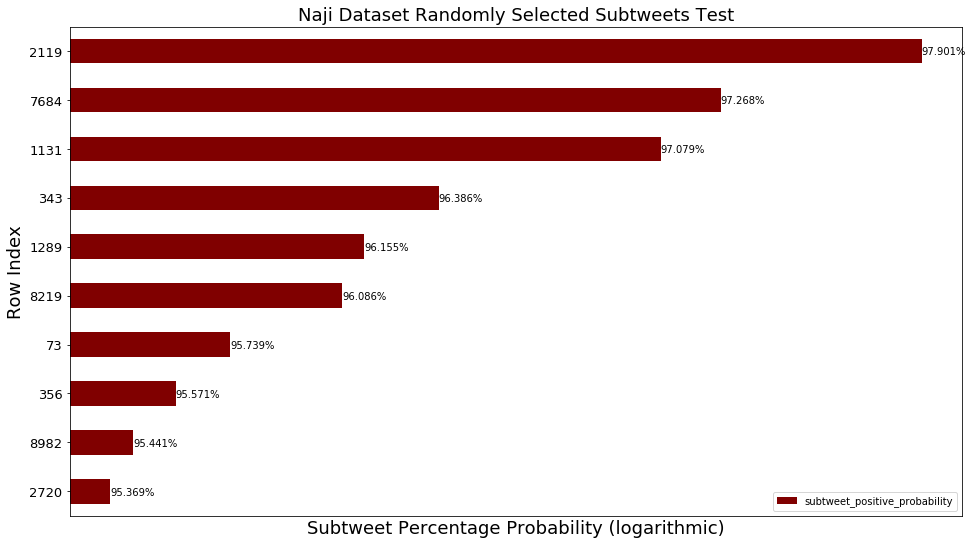

In [29]:
ax = naji_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Naji Dataset Randomly Selected Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Tests on friends' tweets

#### Aaron

In [30]:
aaron_df = pd.read_csv("../data/data_for_testing/friends_data/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [31]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 631 ms, sys: 10.7 ms, total: 642 ms
Wall time: 664 ms


In [32]:
aaron_df.to_csv("../data/data_from_testing/friends_data/akrapf96_tests.csv")

In [33]:
aaron_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [34]:
aaron_df_for_plotting = aaron_df.drop(aaron_df_columns, axis=1).head(10)

In [35]:
aaron_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1722,None,0.017616,0.982384,"PewDiePie posts video ""apologizing"" for his Kill All Jews ""joke"" and it's really about how he makes a ton of money and the media hates him"
3043,None,0.019327,0.980673,when people play shitty music through their microphones
2893,None,0.020232,0.979768,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
3540,None,0.020395,0.979605,Sometimes I wonder if people don't realize the 140 character limit and try to type a really long message and end up having it get cut off at
3236,None,0.021566,0.978434,"What will straight cis people do now with their ""legalize gay"" shirts? Frame them, probably"
3281,None,0.022676,0.977324,What he doesn't know (unless he stalks my twitter which I know he does) is that I have fake accounts following all his social media
919,None,0.022746,0.977254,"ppl putting out wrong info about what the newest pokemon game was, how many pokemon there are now, etc\nI would correct them but I don't want to be ""the video game person"""
1891,None,0.024791,0.975209,The new year has been marked by a shitty NYE performance and shitty fake champagne \nI guess you could say 2017 is off to a great start
2805,None,0.025118,0.974882,"""Best part of the debate is Donald Trump's tweets"" HE'S ONLY RETWEETING PEOPLE NOT POSTING ANYTHING ORIGINAL????"
2811,None,0.026256,0.973744,"Mod: You seem to change your opinions based on political benefit *lists many examples*\nHillary: actually, I'm very consistent\nif u say so"


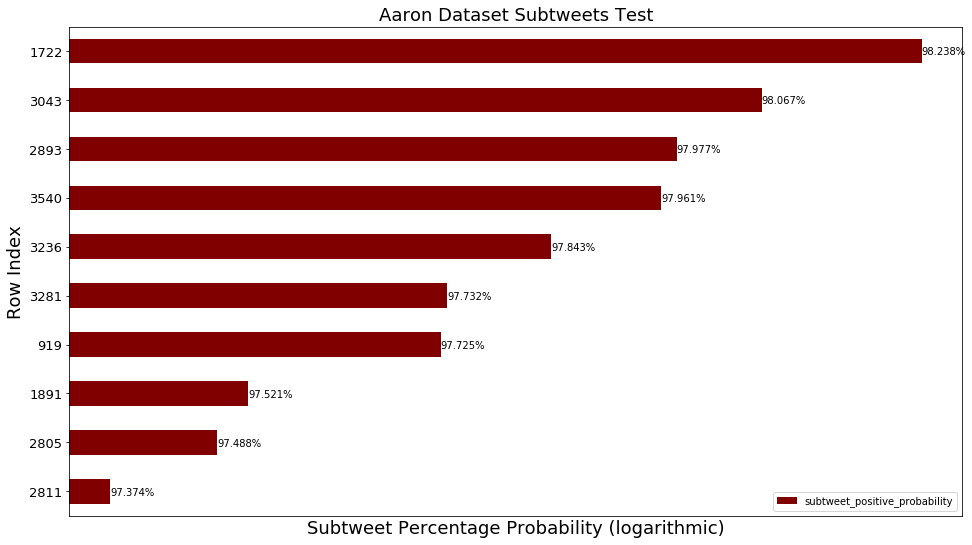

In [36]:
ax = aaron_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Aaron Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Julia

In [37]:
julia_df = pd.read_csv("../data/data_for_testing/friends_data/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [38]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 1.47 s, sys: 20.6 ms, total: 1.49 s
Wall time: 1.51 s


In [39]:
julia_df.to_csv("../data/data_from_testing/friends_data/juliaeberry_tests.csv")

In [40]:
julia_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [41]:
julia_df_for_plotting = julia_df.drop(julia_df_columns, axis=1).head(10)

In [42]:
julia_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
4714,None,0.014852,0.985148,"1 of the most eye-roll inducing things is when some1 posts their writing 4 the sole purpose of showing off how ""good"" they r but it's trash"
3856,None,0.015755,0.984245,god I do not understand why people are obsessed with all of lorde's music and every little thing that she does
5515,None,0.016142,0.983858,when people say they're an empath I hate them even more
902,None,0.016259,0.983741,tbh if they don't start publically dating in a year after pyeongchang I'm going to be S H O C K E D how can you look at somebody like that in programs for 10+ years and not want to marry them
6296,None,0.016607,0.983393,NONE of my fabulous snapchats have made it into the oc snapchat story so to spite them I'm sending them every single snapchat I take
925,None,0.017529,0.982471,"look I mean obviously they're not dating or anything, but even to have an athletic partner be that much older......there's something very weird about that"
1360,None,0.018424,0.981576,"I may be twenty-two years of age, a full-blown adult, but I still harbor my old middle school fantasies of slow-dancing to secondhand serenade's ""fall for you"" one day"
2085,None,0.019480,0.980520,"even at the tender age of 21, I cannot imagine being romantically or sexually interested in an 18 year old. aside from maybe 20 year olds, wanting to date an 18 year old in your twenties makes no sense at all good god"
839,None,0.019532,0.980468,"either tessa and scott are really not dating and are the best actors in the world on the ice, or they're the worst actors in the world off the ice because absolutely nobody is buying the ""just friends"" claim anymore #virtuemoir"
4811,None,0.020133,0.979867,a girl in one of my lit classes constructs her moodle posts w no less than 8 block quotes strewn throughout the post and it makes me ANGERY


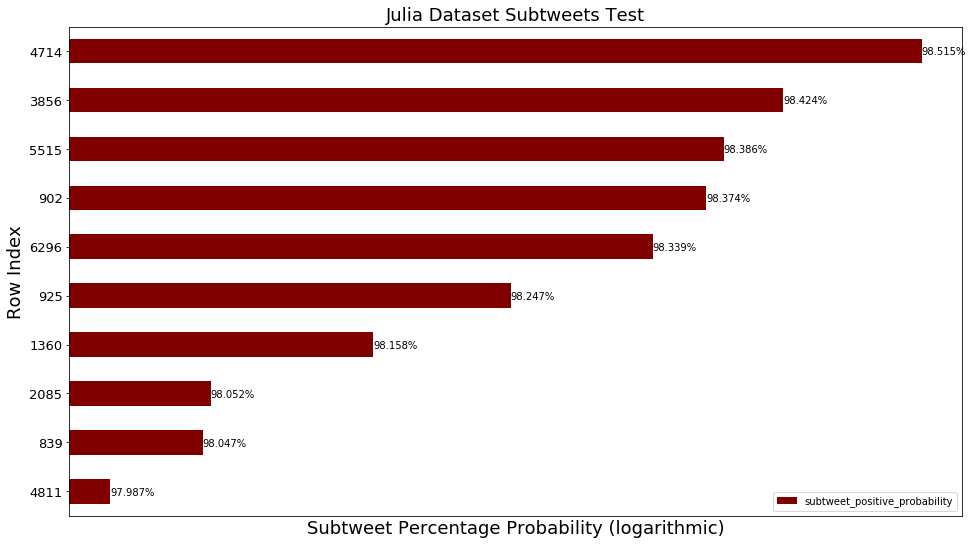

In [43]:
ax = julia_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Julia Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Zoe

In [44]:
zoe_df = pd.read_csv("../data/data_for_testing/friends_data/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [45]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 236 ms, sys: 4.04 ms, total: 240 ms
Wall time: 240 ms


In [46]:
zoe_df.to_csv("../data/data_from_testing/friends_data/zoeterhune_tests.csv")

In [47]:
zoe_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [48]:
zoe_df_for_plotting = zoe_df.drop(zoe_df_columns, axis=1).head(10)

In [49]:
zoe_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
753,None,0.014983,0.985017,no offense but there are maybe like two people who are not annoying on social media
584,None,0.016377,0.983623,the funny thing about anxiety is one minute you could be playing one of your favorite tabletop games w some of your favorite people and then the next you could be having a panic attack in the bathroom bc three people laughing/yelling (in jest) at you suddenly set something off
1105,None,0.024222,0.975778,"The guy who had the audacity to write a Buzzfeed ""article"" called ""28 problems only ridiculously good looking people have"" thinks he's ridiculously good looking when he has the body of a grecian God, sure, and the face of a muppet"
923,None,0.026265,0.973735,sometimes I want to kill the people around me
277,None,0.027629,0.972371,ok so people from my old school keep lamenting the death of someone to whom they claim to be close but also like continually misgender them in their lamentations?? I Don't Like This
1242,None,0.029659,0.970341,"Legit conversation outside robbins: ""dead ass 55% of men get prostate cancer by the age of 50...y do they need 2 raise awareness for that?"""
547,None,0.031900,0.968100,"if ""definitive"" lists of the worst to best episodes of black mirror have taught me anything it's that people should stop writing lists like these"
803,None,0.032017,0.967983,the fact that twitter shows tweets people you follow have liked means that sub-liking is also a thing
848,None,0.033012,0.966988,that one buzzfeed employee who thinks they're really funny but they aren't
756,None,0.033033,0.966967,I wonder what it's like to play fortnite\n\nor any online games for that matter


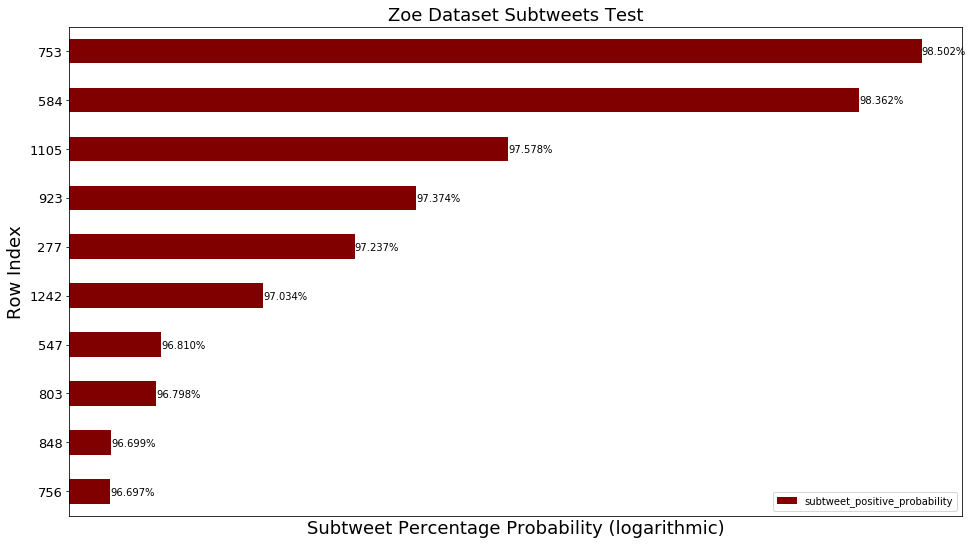

In [50]:
ax = zoe_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Zoe Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Noah

In [51]:
noah_df = pd.read_csv("../data/data_for_testing/friends_data/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [52]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

CPU times: user 856 ms, sys: 13.4 ms, total: 869 ms
Wall time: 893 ms


In [53]:
noah_df.to_csv("../data/data_from_testing/friends_data/noahsegalgould_tests.csv")

In [54]:
noah_df_columns = ["sentiment_score", "subtweet_negative_probability", "tweet"]

In [55]:
noah_df_for_plotting = noah_df.drop(noah_df_columns, axis=1).head(10)

In [56]:
noah_df.head(10)

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
3525,None,0.012594,0.987406,some people want their kids to take care of them when they are elderly but I plan to enslave sentient AI to do that for me until the end.
2908,None,0.015311,0.984689,It's one of those stories about someone who can't take anything seriously until everything goes to shit and then he's forced to change
4024,None,0.016217,0.983783,Being human means reconciling what you want with what everyone else wants and I know that but it's so damn hard sometimes.
2629,None,0.016221,0.983779,"My mom notices when I put extra effort into being emotionally and physically present but I hate it, maybe because I hate the effort it takes"
3712,None,0.017643,0.982357,Do I confront someone I barely know to explain to them that they can't just drink out of my water bottle without asking?
877,None,0.018224,0.981776,I guess I think it’s foolish to rely on any website for being your source of personal fulfillment and especially as your only source for political change. The companies which own your speech aren’t going to let you dismantle them. And their goal isn’t ever going to be to help...
3441,None,0.020677,0.979323,Website idea: a twitter clone but only for nazis and white supremacists but nobody reads the terms of service and I tell all their parents
201,None,0.020836,0.979164,"I guy in my algorithms class commented on a facebook post from the guy who thinks he's the son of god saying ""can I have what you're on"" and the divine fellow said he's high on spirit but the algorithms guy is the head of the hookah club"
1042,None,0.021353,0.978647,Someone in the class of 2021 Facebook group wanted to know when they get their final grades and I told them May 2021
624,None,0.022390,0.977610,things people do differently that nobody talks about:\n\nsleeping positions\nsleeping clothing options\nass wiping \nloofa ownership\nwho you look at when you laugh aloud in a group of friends implying you feel the strongest connection with that unintentionally chosen individual


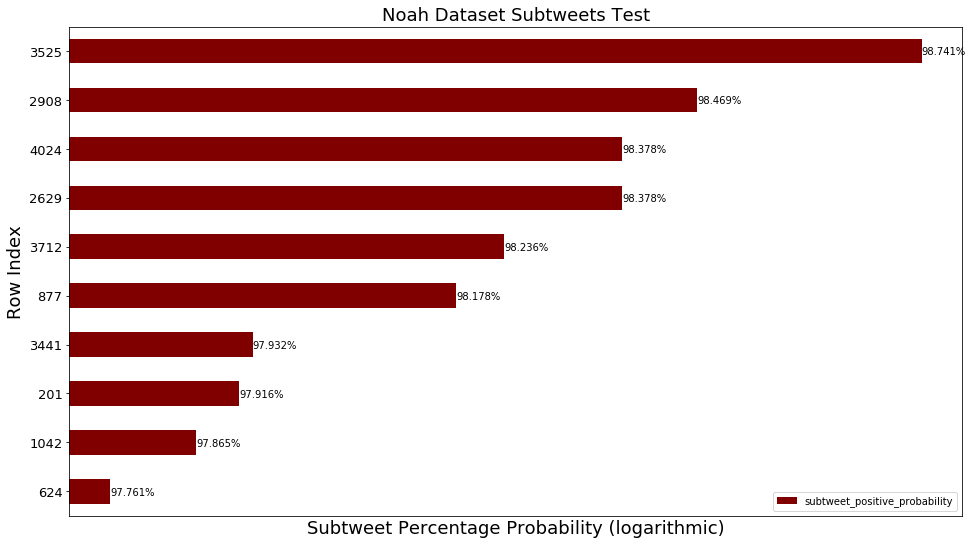

In [57]:
ax = noah_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Noah Dataset Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()

#### Test it in realtime
#### Define some useful variables for later

In [58]:
THRESHOLD = 0.95 # 95% positives and higher, only
DURATION = 60 # 1 minute

#### Load Twitter API credentials

In [59]:
consumer_key, consumer_secret, access_token, access_token_secret = open("../../credentials.txt").read().split("\n")

#### Use the API credentials to connect to the API

In [60]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, retry_delay=1, timeout=120, # 2 minutes
                 compression=True, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Prepare the final dataframe

In [61]:
subtweets_live_list = []
non_subtweets_live_list = []

#### Create a custom class for streaming subtweets

In [62]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        choices = ["retweet", "like", "retweet and like", "reply"]
        
        id_str = status.id_str
        screen_name = status.user.screen_name
        created_at = status.created_at
        retweeted = status.retweeted
        in_reply_to = status.in_reply_to_status_id
        
        text = status.text.replace("&quot;", "\"").replace("&amp;", "&").replace("&gt;", ">").replace("&lt;", "<")
        
        # negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        
        row = {"tweet": text, 
               "screen_name": screen_name, 
               "time": created_at, 
               "subtweet_probability": positive_probability}
        
        print_list = pd.DataFrame([row]).values.tolist()[0]
        
        if all([positive_probability >= THRESHOLD, 
                not retweeted,
                "RT @" not in text, 
                not in_reply_to]):
            
            decision = choice(choices)
            if decision == "retweet":
                api.update_status(("Is this a subtweet? {:.3%} \n" + 
                                   "https://twitter.com/{}/status/{}").format(positive_probability, 
                                                                              screen_name, 
                                                                              id_str))
            
            if decision == "like":
                api.create_favorite(id_str)
            
            if decision == "retweet and like":
                api.update_status(("Is this a subtweet? {:.3%} \n" + 
                                   "https://twitter.com/{}/status/{}").format(positive_probability, 
                                                                              screen_name, 
                                                                              id_str))
                api.create_favorite(id_str)
            
            if decision == "reply":
                api.update_status("@{} Is this a subtweet? {:.3%}".format(screen_name, positive_probability), id_str)
            
            subtweets_live_list.append(row)
            subtweets_df = pd.DataFrame(subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                         ascending=False)
            
            subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv")
            
            print(("Subtweet from @{0} (Probability of {1:.3%}):\n" + 
                   "Time: {2}\n" + 
                   "Tweet: {3}\n" +
                   "Total tweets acquired: {4}\n").format(print_list[0], 
                                                          print_list[1], 
                                                          print_list[2],
                                                          print_list[3],
                                                          (len(subtweets_live_list) 
                                                           + len(non_subtweets_live_list))))
            
            return row
        else:
            non_subtweets_live_list.append(row)
            non_subtweets_df = pd.DataFrame(non_subtweets_live_list).sort_values(by="subtweet_probability", 
                                                                                 ascending=False)
            non_subtweets_df.to_csv("../data/data_from_testing/live_downloaded_data/non_subtweets_live_data.csv")
            
            return row

#### Get a list of the IDs of all my mutuals and my mutuals' followers

In [63]:
def get_mutuals():
    my_followers = [str(user_id) for ids_list in 
                    tweepy.Cursor(api.followers_ids, 
                                  screen_name="NoahSegalGould").pages() 
                    for user_id in ids_list]
    my_followeds = [str(user_id) for ids_list in 
                   tweepy.Cursor(api.friends_ids, 
                                 screen_name="NoahSegalGould").pages() 
                   for user_id in ids_list]
    
    my_mutuals = list(set(my_followers) & set(my_followeds))
    
    bots = ["890031065057853440", "895685688582180864", 
            "894658603977777152", "970553455709446144", 
            "786489395519983617", "975981192817373184"]
    
    my_mutuals = [m for m in my_mutuals if m not in bots]
    
    with open("../data/other_data/NoahSegalGould_Mutuals_ids.json", "w") as outfile:
        json.dump(my_mutuals, outfile)
    
    return my_mutuals

In [64]:
def get_mutuals_and_mutuals_mutuals_ids(mutuals_threshold=250):
    my_mutuals = get_mutuals()
    my_mutuals_mutuals = my_mutuals[:]

    for i, mutual in enumerate(my_mutuals):
        start_time = time()
        user = api.get_user(user_id=mutual)
        name = user.screen_name
        is_protected = user.protected
        if not is_protected:
            mutuals_followers = []
            followers_cursor = tweepy.Cursor(api.followers_ids, user_id=mutual).items()
            while True:
                try:
                    mutuals_follower = followers_cursor.next()
                    mutuals_followers.append(str(mutuals_follower))
                except tweepy.TweepError:
                    sleep(30) # 30 seconds
                    continue
                except StopIteration:
                    break
            mutuals_followeds = []
            followeds_cursor = tweepy.Cursor(api.friends_ids, user_id=mutual).items()
            while True:
                try:
                    mutuals_followed = followeds_cursor.next()
                    mutuals_followeds.append(str(mutuals_followed))
                except tweepy.TweepError:
                    sleep(30) # 30 seconds
                    continue
                except StopIteration:
                    break
            mutuals_mutuals = list(set(mutuals_followers) & set(mutuals_followeds))
            print("{} mutuals for mutual {}: {}".format(len(mutuals_mutuals), i+1, name))
            if len(mutuals_mutuals) <= mutuals_threshold: # Ignore my mutuals if they have a lot of mutuals
                my_mutuals_mutuals.extend(mutuals_mutuals)
            else:
                print("\tSkipping: {}".format(name))
        else:
            continue
        end_time = time()
        with open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json", "w") as outfile:
            json.dump(my_mutuals_mutuals, outfile)
        print("{0:.2f} seconds for getting the mutuals' IDs of mutual {1}: {2}\n".format((end_time - start_time), 
                                                                                         i+1, name))
    my_mutuals_mutuals = [str(mu) for mu in sorted([int(m) for m in list(set(my_mutuals_mutuals))])]
    with open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json", "w") as outfile:
        json.dump(my_mutuals_mutuals, outfile, indent=4)
    return my_mutuals_mutuals

In [65]:
# %%time
# my_mutuals_mutuals = get_mutuals_and_mutuals_mutuals_ids()

In [66]:
%%time
my_mutuals = get_mutuals()

CPU times: user 42.6 ms, sys: 12.9 ms, total: 55.5 ms
Wall time: 345 ms


In [67]:
my_mutuals_mutuals = json.load(open("../data/other_data/NoahSegalGould_Mutuals_and_Mutuals_Mutuals_ids.json"))

In [68]:
print("Total number of my mutuals: {}".format(len(my_mutuals)))

Total number of my mutuals: 107


In [69]:
print("Total number of my mutuals and my mutuals' mutuals: {}".format(len(my_mutuals_mutuals)))

Total number of my mutuals and my mutuals' mutuals: 4218


#### Instantiate the listener

In [70]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [71]:
%%time
# stream.filter(locations=[-73.920176, 42.009637, -73.899739, 42.033421], stall_warnings=True, languages=["en"], async=True)
stream.filter(follow=my_mutuals_mutuals, stall_warnings=True, languages=["en"], async=True)
print("Streaming has started.")
sleep(DURATION)
stream.disconnect()

Streaming has started.


/Users/Noah/anaconda/envs/work/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


CPU times: user 493 ms, sys: 63.7 ms, total: 557 ms
Wall time: 1min


#### Plot the results

In [ ]:
subtweets_df = pd.read_csv("../data/data_from_testing/live_downloaded_data/subtweets_live_data.csv", index_col=0)

In [ ]:
subtweets_df_columns = ["screen_name", "time", "tweet"]

In [ ]:
subtweets_df_for_plotting = subtweets_df.drop(subtweets_df_columns, axis=1).head(10)

In [ ]:
subtweets_df.head(10)

In [ ]:
ax = subtweets_df_for_plotting.plot.barh(logx=True, figsize=(16, 9), color="maroon", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Live Downloaded Subtweets Test", fontsize=18)
ax.set_ylabel("Row Index", fontsize=18);
ax.set_xlabel("Subtweet Percentage Probability (logarithmic)", fontsize=18);
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.325, "{:.3%}".format(i.get_width()), fontsize=10, color="black")
ax.invert_yaxis()